In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import pandas as pd
energy = pd.read_csv('/content/energy_dataset.csv')
weather = pd.read_csv('/content/weather_features.csv')

#Preprocessing phase

In [14]:
energy['time'] = pd.to_datetime(energy['time'], utc=True, infer_datetime_format=True)
energy['time'] = pd.to_datetime(energy['time'].astype(str)) + pd.DateOffset(hours=1, minutes=0)
energy = energy.set_index('time')

In [15]:
weather['time'] = pd.to_datetime(weather['dt_iso'], utc=True, infer_datetime_format=True)
weather = weather.drop(['dt_iso'], axis=1)
weather['time'] = pd.to_datetime(weather['time'].astype(str)) + pd.DateOffset(hours=1, minutes=0)
weather = weather.set_index('time')

In [16]:
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import numpy as np
#Define a treshold to delete zero values
threshold = 0.7

columns = energy.columns
nb_observations = len(energy)

arr_percentage_zeros = []
cols_to_remove = []

for label in columns:
  percentage = len(energy[energy[label] == 0]) / nb_observations

  if percentage > threshold:
    cols_to_remove.append(label)
  
  arr_percentage_zeros.append(percentage)

fig = go.Figure(data=[go.Scatter(x=columns, y=arr_percentage_zeros, mode="markers + lines", name="percentage of zeros"),
                      go.Scatter(x=columns, y=[threshold for i in arr_percentage_zeros], name="threshold", line=dict(dash='dot'))])

fig.show()

In [17]:
# Drop variables with 0 values > 0.7 of the data
energy = energy.drop(labels=cols_to_remove, axis=1)

In [22]:
from scipy.stats import skew, norm, boxcox_normmax
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in energy.columns:
    if energy[i].dtype in numeric_dtypes:
        numeric.append(i)

skew_features = energy[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features.head(10)

There are 2 numerical features with Skew > 0.5 :


forecast solar day ahead                0.989975
forecast wind onshore day ahead         0.800385
total load forecast                     0.059871
price actual                           -0.323735
price day ahead                        -0.487750
generation biomass                           NaN
generation fossil brown coal/lignite         NaN
generation fossil gas                        NaN
generation fossil hard coal                  NaN
generation fossil oil                        NaN
dtype: float64

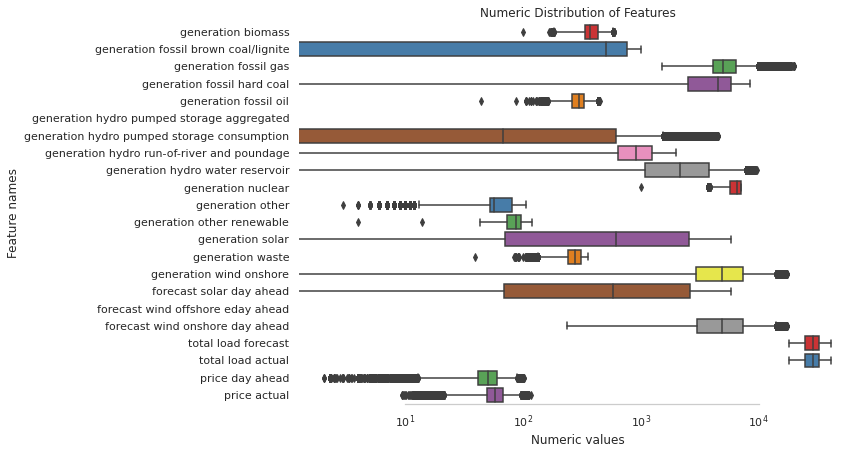

In [23]:
# Create box plots for all numeric features
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style("white")
sns.set(style="whitegrid", color_codes=True)
f, ax = plt.subplots(figsize=(10, 7))
ax.set_xscale("log")
ax = sns.boxplot(data=energy[numeric] , orient="h", palette="Set1")
ax.xaxis.grid(False)
ax.set(ylabel="Feature names")
ax.set(xlabel="Numeric values")
ax.set(title="Numeric Distribution of Features")
sns.despine(trim=True, left=True)

In [24]:
# Dropping variables with 100 %NAN values + forecast variables
energy = energy.drop(['generation hydro pumped storage aggregated','forecast wind offshore eday ahead','total load forecast', 'forecast solar day ahead','forecast wind onshore day ahead','price day ahead'], axis=1)

In [25]:
# fill NAN values with linear interpolation
energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [26]:
weather = weather.reset_index().drop_duplicates(subset=['time', 'city_name'],keep='first').set_index('time')

In [27]:
weather=weather.drop(['weather_main','weather_id','weather_icon'], axis=1)

In [28]:
weather.loc[weather.pressure > 1050, 'pressure'] = np.nan
weather.loc[weather.pressure < 950, 'pressure'] = np.nan
weather.loc[weather.wind_speed > 25, 'wind_speed'] = np.nan
weather['pressure'] = weather['pressure'].interpolate(method = 'linear', limit_direction = 'forward')
weather['wind_speed'] = weather['wind_speed'].interpolate(method = 'linear', limit_direction = 'forward')

# Merging datas

In [29]:
weather_1, weather_2, weather_3, weather_4, weather_5 = [(city, table) for (city, table) in weather.groupby('city_name')]
weathers = [weather_1, weather_2, weather_3, weather_4, weather_5]
weathergy = energy

for (city, table) in weathers:
  data = table.add_suffix('_{}'.format(city))
  data = data.rename(columns = {'time_{}'.format(city) : 'time'})
  data = data.drop('city_name_{}'.format(city), axis = 1)
  weathergy = pd.merge(left = weathergy, right = data, on = 'time', how = 'outer')

# Hourly mean energy demand for each year

In [30]:
# Depicting average hourly electricity demand :
group_hours = weathergy['total load actual'].groupby(pd.Grouper(freq = 'D', how = 'mean'))
year_demands = pd.DataFrame()

for name, group in group_hours :
  year_demands[name.year] = pd.Series(group.values)

H = list(range(24))
hours = []
for h in H :
  h = str(h) + ':00'
  hours.append(h)

avg_daily_load = []
for year in year_demands.columns :
  leg = 'Average hourly demand in ' + str(year)
  plot = go.Scatter(x = hours, y = year_demands[year], mode = "markers + lines", name = leg)
  avg_daily_load.append(plot)

fig = go.Figure(data = avg_daily_load)
fig.update_layout(height = 800, width = 1800, title_text = "Depicting average hourly electricity demand", xaxis_title = 'Daily Hours', yaxis_title = 'Energy Demand (MWh)')
fig.show()

In [31]:
data_columns = ['price actual','total load actual','generation hydro pumped storage consumption','generation solar','generation wind onshore','generation nuclear','generation biomass','generation fossil gas','generation fossil hard coal']
weathergy_mean = weathergy[data_columns].resample('W').mean()
weathergy_mean.head(3)

,price actual,total load actual,generation hydro pumped storage consumption,generation solar,generation wind onshore,generation nuclear,generation biomass,generation fossil gas,generation fossil hard coal
time,,,,,,,,,
2015-01-04 00:00:00+00:00,63.861667,25842.833333,1135.635417,1479.447917,8041.718750,7095.458333,412.854167,3677.822917,2268.187500
2015-01-11 00:00:00+00:00,72.199048,27185.982143,562.202381,1789.875000,5101.104167,5624.535714,498.306548,4833.616071,5847.377976
2015-01-18 00:00:00+00:00,65.518631,30976.785714,677.202381,715.833333,6554.178571,6865.779762,498.982143,5648.636905,6130.434524


# weekly mean price actual

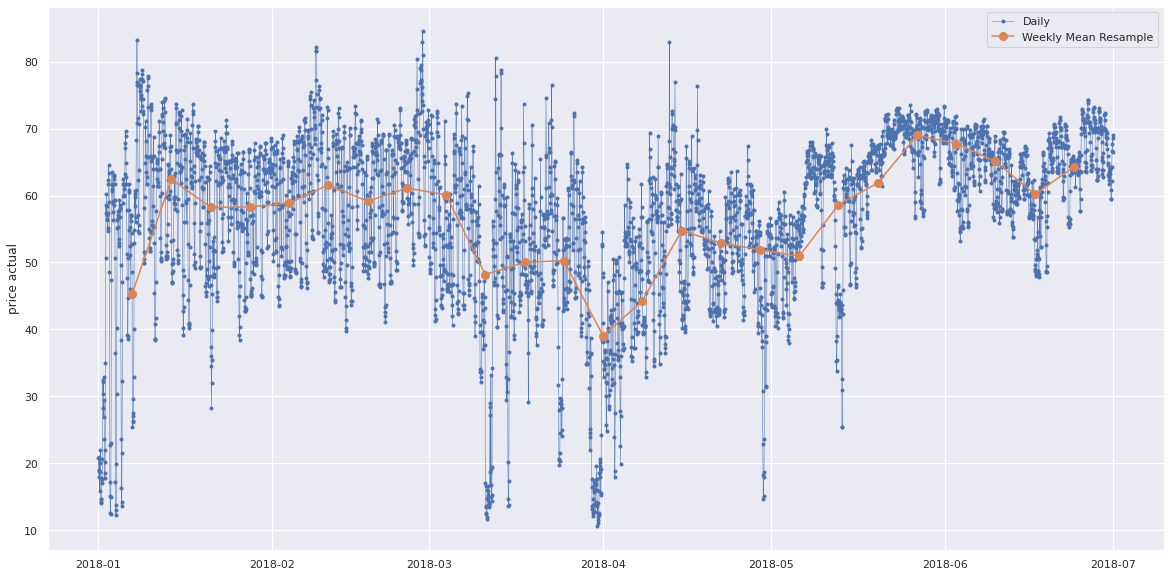

In [33]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(20, 10)})
import matplotlib.pyplot as plt
start, end = '2018-01', '2018-06'
fig, ax = plt.subplots()
ax.plot(weathergy.loc[start:end, 'price actual'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(weathergy_mean.loc[start:end, 'price actual'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('price actual')
ax.legend();

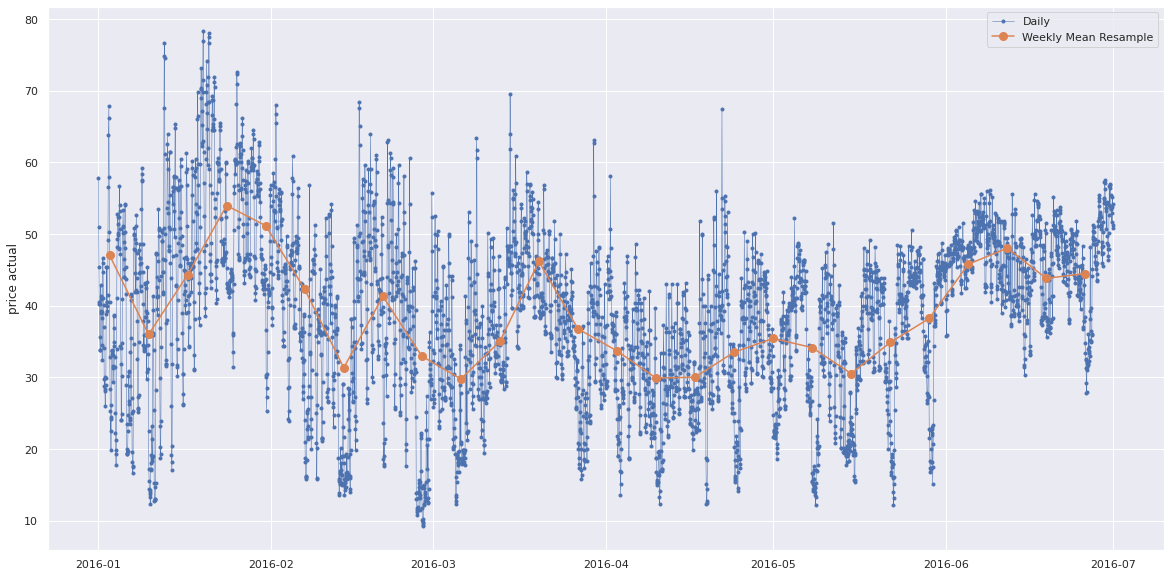

In [34]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(20, 10)})
import matplotlib.pyplot as plt
start, end = '2016-01', '2016-06'
fig, ax = plt.subplots()
ax.plot(weathergy.loc[start:end, 'price actual'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(weathergy_mean.loc[start:end, 'price actual'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('price actual')
ax.legend();

In [35]:
weathergy['time'] = weathergy.index
weathergy['hour'] = weathergy['time'].dt.hour
weathergy['weekday'] = weathergy['time'].dt.dayofweek
weathergy['month'] = weathergy['time'].dt.month
weathergy['year'] = weathergy['time'].dt.year
weathergy['date'] = weathergy['time'].dt.date

In [36]:
weathergy_15_07 = weathergy.loc['2015-07']
weathergy_17_07 = weathergy.loc['2017-07']

# Monthly zoom price variations

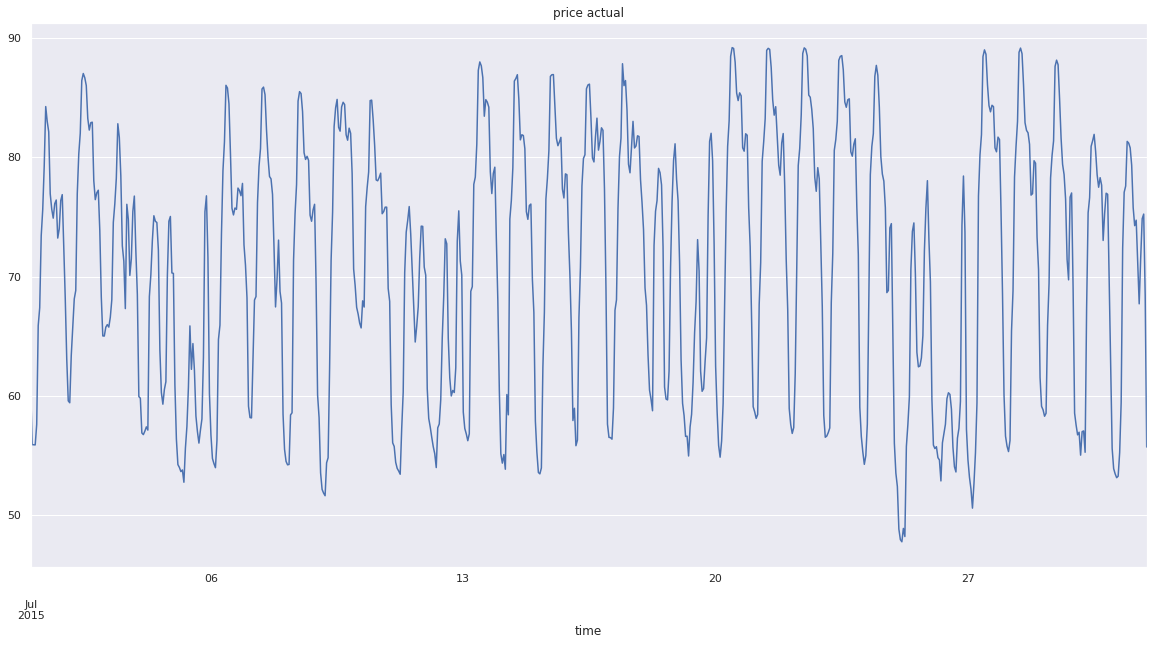

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 10)})
weathergy_15_07['price actual'].plot(linewidth=1.5,title = 'price actual');

In [38]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=30)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



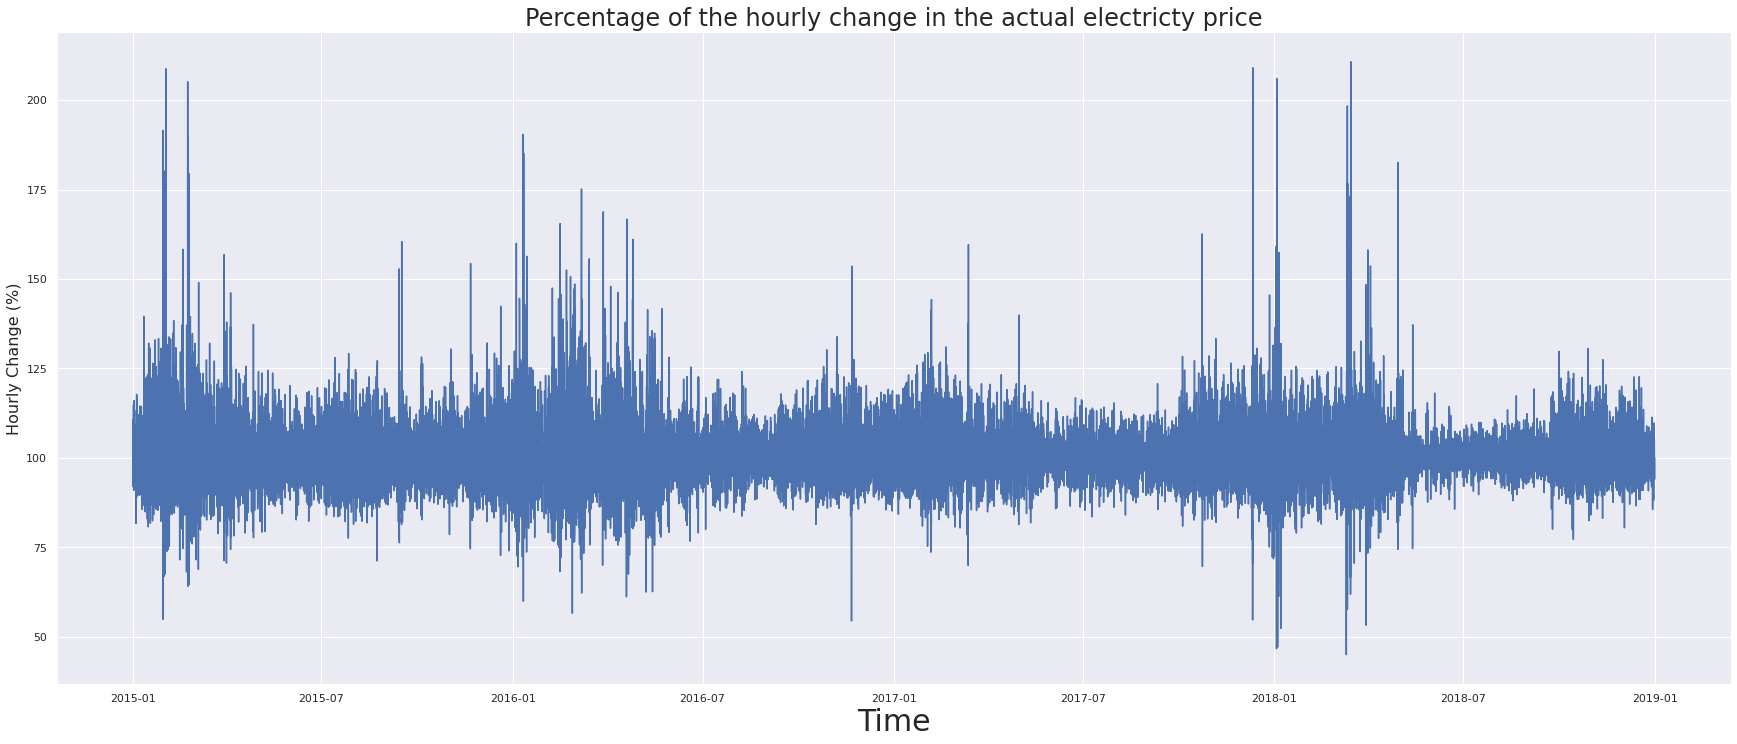

In [39]:
change = weathergy['price actual'].div(weathergy['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

Text(0.5, 1.0, 'price')

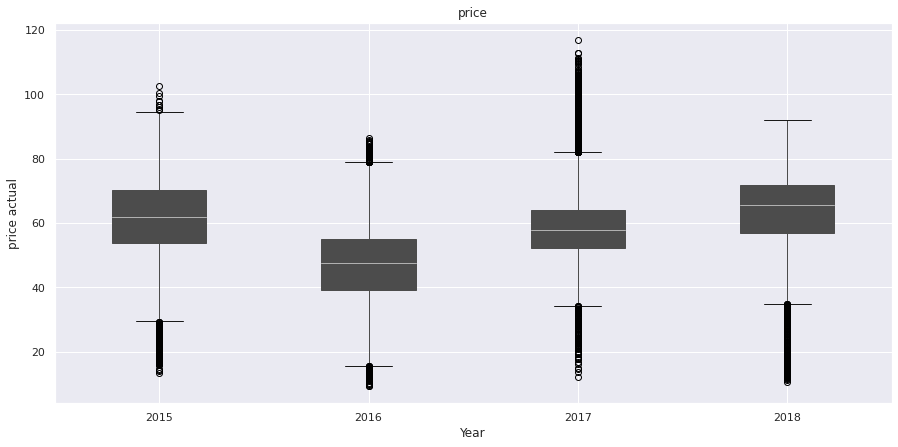

In [40]:
fig, axs = plt.subplots(1, 1, figsize=(15,7))
df = pd.DataFrame()
groups = weathergy['price actual'].groupby(pd.Grouper(freq='A'))
for name, group in groups:
    df[name.year] = pd.Series(group.values)
df.boxplot(ax=axs,patch_artist=True)
axs.set_xlabel('Year')
axs.set_ylabel('price actual')
axs.set_title('price')

In [41]:
weathergy_15 = weathergy.loc['2015']
weathergy_16 = weathergy.loc['2016']

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Text(0.5, 1.0, 'price')

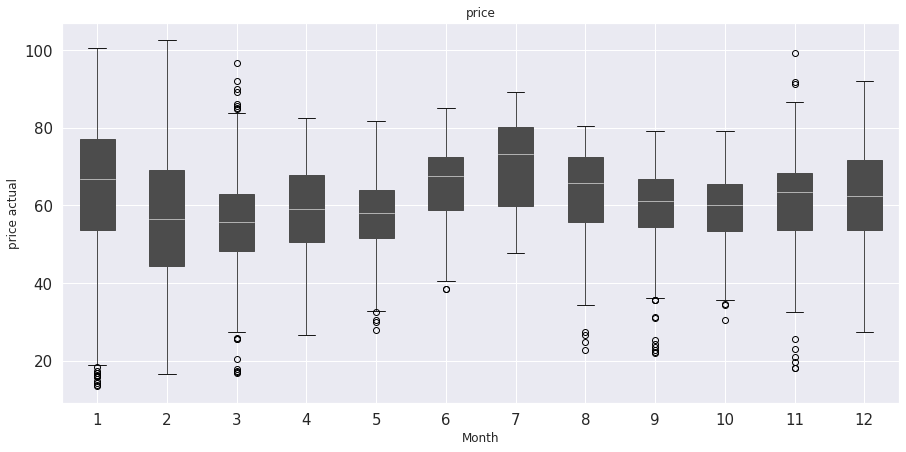

In [43]:
fig, axs = plt.subplots(1, 1, figsize=(15,7),sharex=True)
df = pd.DataFrame()
groups = weathergy_15['price actual'].groupby(pd.Grouper(freq='M'))
for name, group in groups:
    df[name.month] = pd.Series(group.values)
df.boxplot(ax=axs,patch_artist=True, fontsize = 15 )
axs.set_xlabel('Month')
axs.set_ylabel('price actual')
axs.set_title('price')

# Price dropping between 2015 and 2016

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



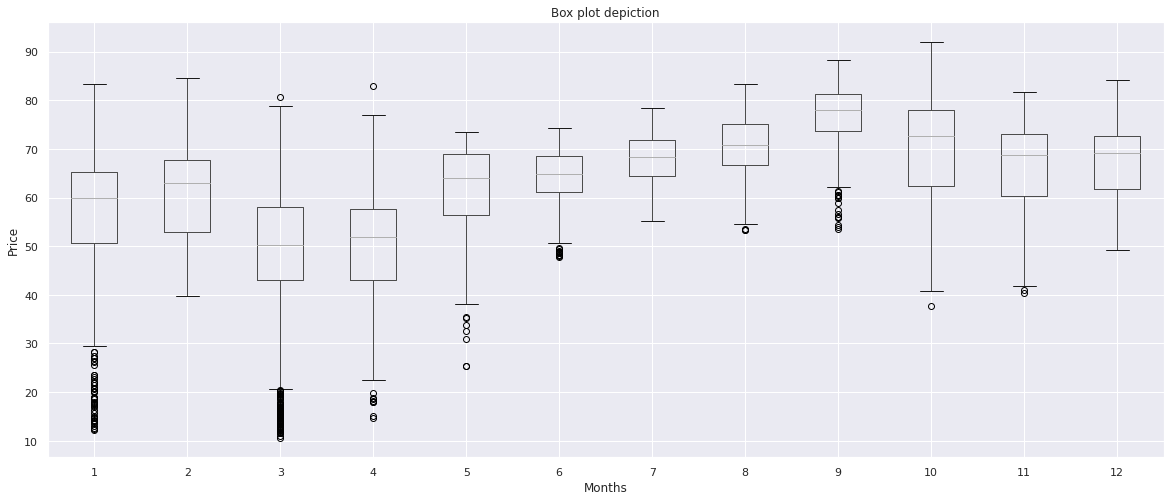

In [44]:
groups = weathergy.set_index('time')['price actual'].groupby(pd.Grouper(freq = 'M', how = 'mean'))

df = pd.DataFrame()

for name, group in groups:
    df[name.month] = pd.Series(group.values)

plt.figure(figsize = (20, 8))

df.boxplot()

plt.xlabel('Months')
plt.ylabel('Price')
plt.title('Box plot depiction')

plt.show()

In [45]:
frames = [weathergy_15, weathergy_16]
weathergy_15_16 = pd.concat(frames)

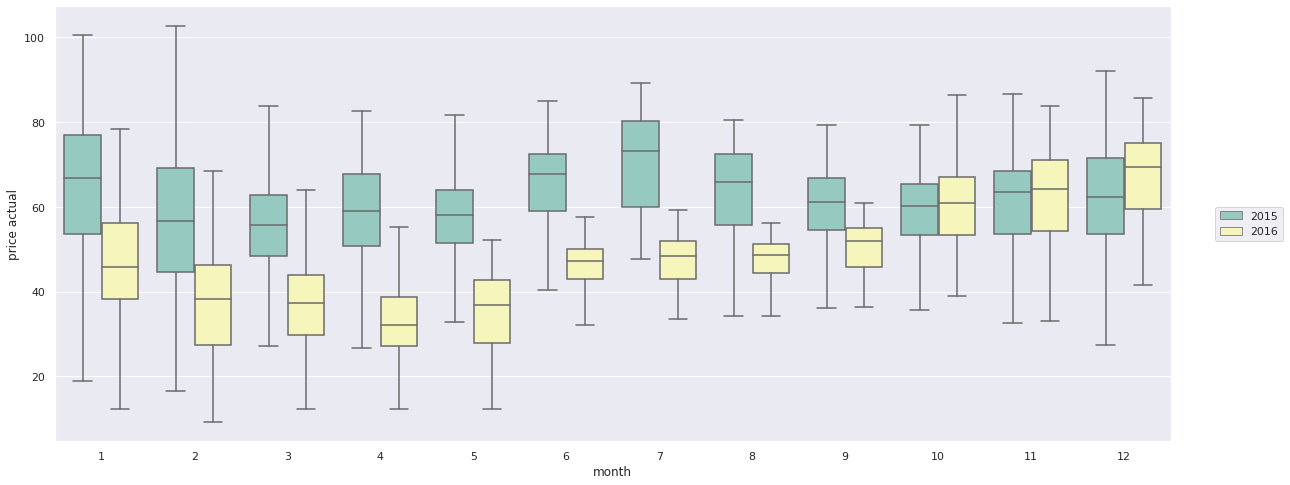

In [46]:
sns.set_style
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(x='month',y ='price actual',data=weathergy_15_16,showfliers=False,palette="Set3",hue='year')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [48]:
data_columns = ['price actual','total load actual','generation hydro pumped storage consumption','generation solar','generation wind onshore','generation nuclear','generation biomass','generation fossil gas','generation fossil hard coal']

In [49]:
weathergy_annual = weathergy[data_columns].resample('A').sum(min_count=360)
weathergy_annual = weathergy_annual.set_index(weathergy_annual.index.year)
weathergy_annual.index.name = 'Year'
weathergy_annual['hydro + wind + solar / total load actual'] = (weathergy_annual['generation hydro pumped storage consumption']+weathergy_annual['generation solar']+weathergy_annual['generation wind onshore'])/ weathergy_annual['total load actual']

In [50]:
data_columns = ['hydro + wind + solar / total load actual','price actual','total load actual','generation hydro pumped storage consumption','generation solar','generation wind onshore','generation nuclear','generation biomass','generation fossil gas','generation fossil hard coal']

In [51]:
weathergy_15_16['renewables'] = (weathergy_15_16['generation hydro water reservoir']+weathergy_15_16['generation solar']+weathergy_15_16['generation wind onshore']+weathergy_15_16['generation other renewable'])

#Hydro energy variations between 2015-2016

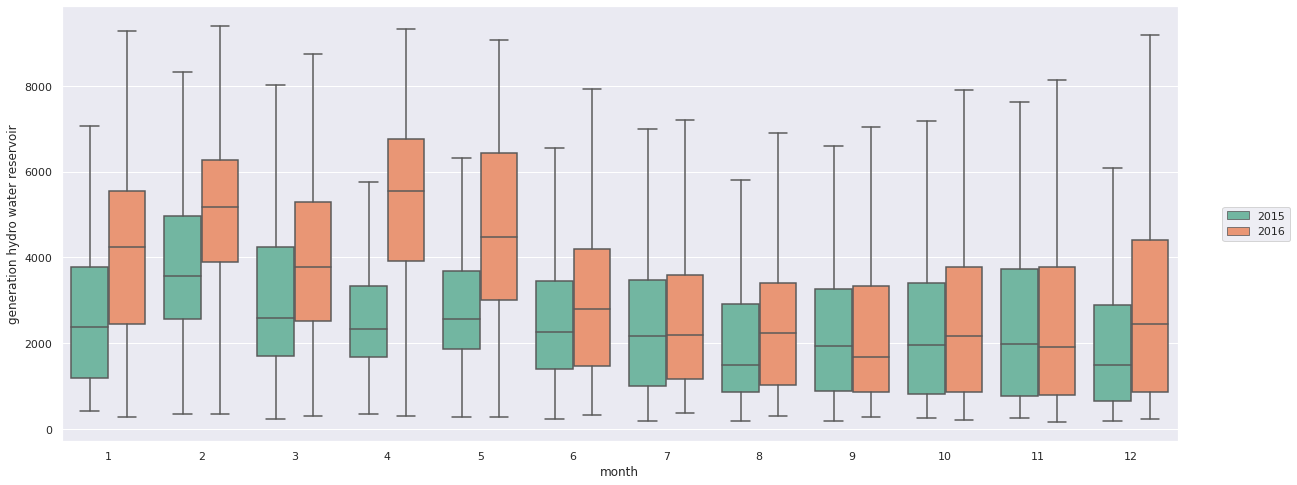

In [47]:
sns.set_style
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(x='month',y ='generation hydro water reservoir',data=weathergy_15_16,showfliers=False,palette="Set2",hue='year')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

# Some high renewable sources variations

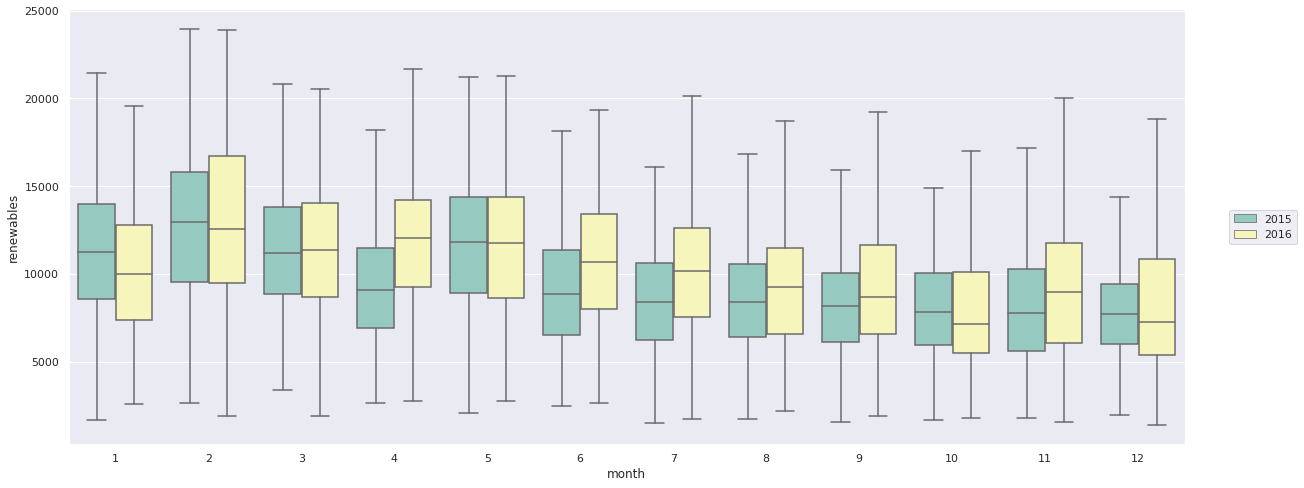

In [52]:
sns.set_style
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(x='month',y ='renewables',data=weathergy_15_16,showfliers=False,palette="Set3",hue='year')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

#Trends in electriciy price

In [55]:
data_columns1 = ['price actual']

In [56]:
weathergy_365d = weathergy[data_columns1].rolling(window=365, center=True, min_periods=360).mean()

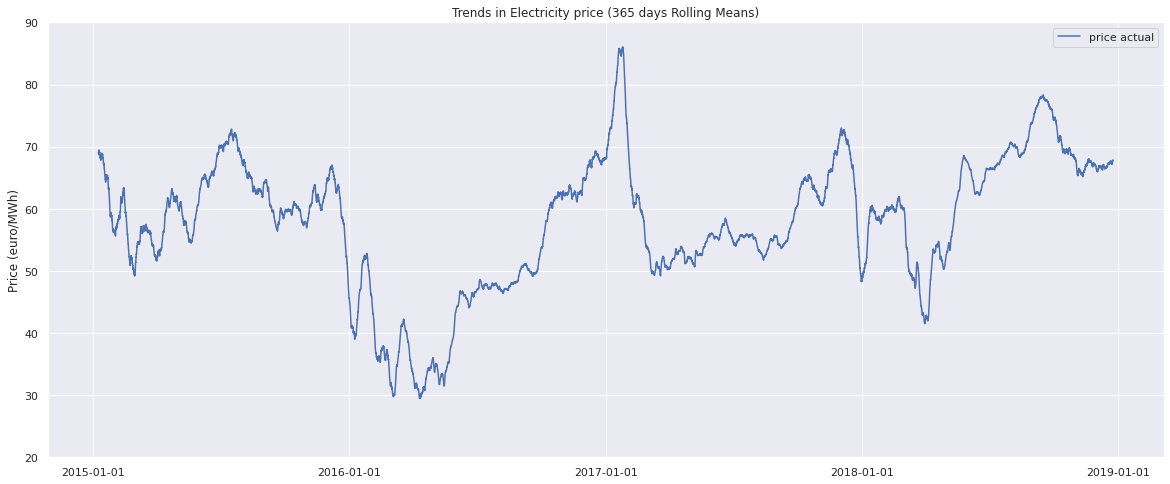

In [58]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.plot(weathergy_365d['price actual'], label='price actual')
    # Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylim(20, 90)
ax.legend()
ax.set_ylabel('Price (euro/MWh)')
ax.set_title('Trends in Electricity price (365 days Rolling Means)');

#Trends in total load

In [61]:
data_columns3 = ['total load actual']

In [62]:
weathergy_3651 = weathergy[data_columns3].rolling(window=365, center=True, min_periods=360).mean()

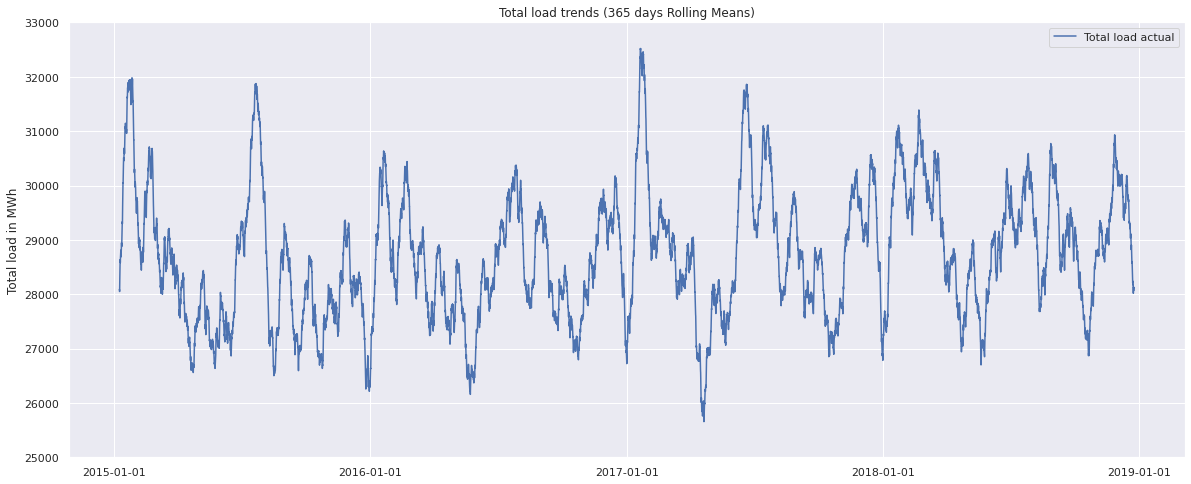

In [63]:
fig, ax = plt.subplots()
ax.plot(weathergy_3651['total load actual'], label='Total load actual')
    # Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylim(25000, 33000)
ax.legend()
ax.set_ylabel('Total load in MWh')
ax.set_title('Total load trends (365 days Rolling Means)');

In [64]:
weathergy_15 = weathergy.loc['2015']
weathergy_16 = weathergy.loc['2016']
frames = [weathergy_15, weathergy_16]
weathergy_15_16 = pd.concat(frames)

In [65]:
weathergy['renewables'] = weathergy['generation hydro water reservoir']+weathergy['generation solar']+weathergy['generation wind onshore']+weathergy['generation nuclear']
weathergy['fossil'] = weathergy['generation fossil gas']+weathergy['generation fossil hard coal']+weathergy['generation fossil brown coal/lignite']

# Trends in fossils vs renewables

In [66]:
data_columns4= ['renewables', 'fossil']

In [67]:
weathergy_3652 = weathergy[data_columns4].rolling(window=365, center=True, min_periods=360).mean()

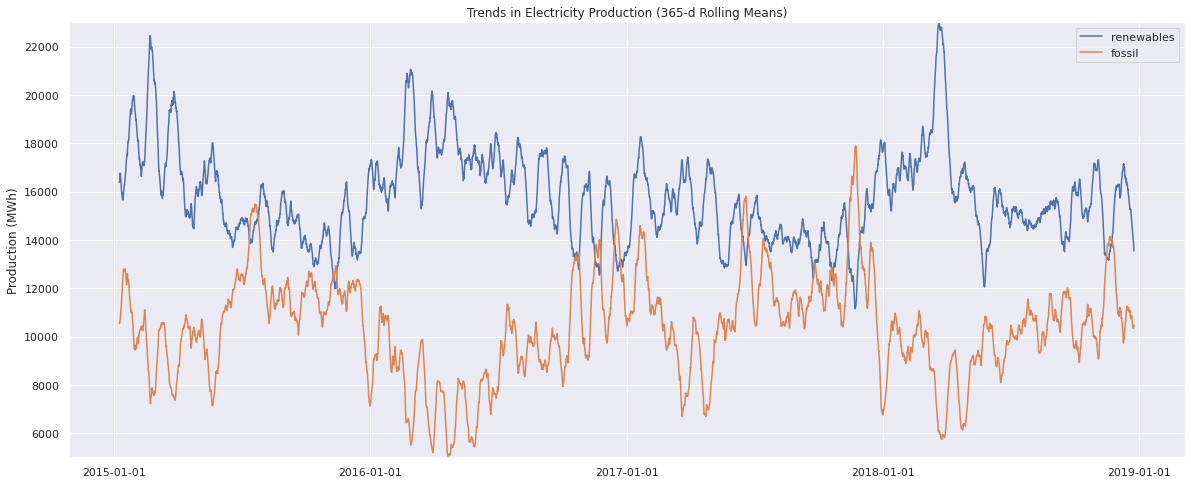

In [68]:
# Plot 365-day rolling mean time series of wind and solar power
fig, ax = plt.subplots()
for nm in [ 'renewables', 'fossil']:
    ax.plot(weathergy_3652[nm], label=nm)
    # Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.set_ylim(5000, 23000)
    ax.legend()
    ax.set_ylabel('Production (MWh)')
    ax.set_title('Trends in Electricity Production (365-d Rolling Means)');